<a href="https://colab.research.google.com/github/sahil301290/TSS2022-ThaparSummerSchool/blob/main/30Jun2022_FashionMNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import Libraries**

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)
import cv2

Tensorflow version: 2.8.2


In [2]:
# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

## **2. Load and Preprocess the Data**

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4431872/4422102 [==============================] - 0s 0us/step


## **3. Visualizing Training Data**

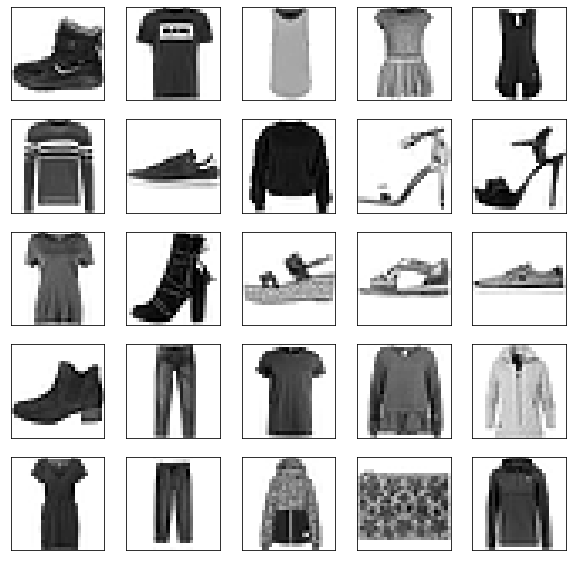

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## **4. Create Batches of Training Data**

In [5]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
#Creates a Dataset that prefetches elements from this dataset

## **DCGAN Instructions:**
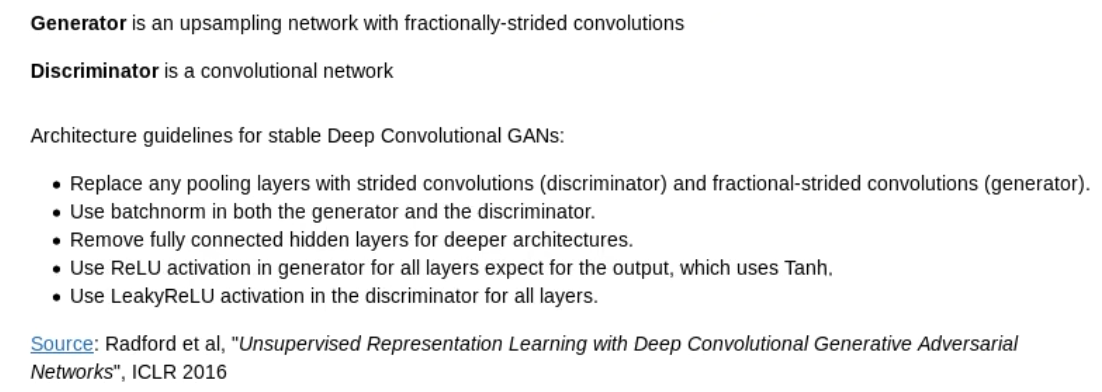

## **5. Build the Generator Network for DCGAN**

In [ ]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 256, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, (5,5), (1,1), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)

In [ ]:
generated_images.shape

TensorShape([1, 28, 28, 1])

In [ ]:
type(generated_images)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
g = np.array(generated_images)
g = np.reshape(g,g.shape[1:])
g.shape

(28, 28, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


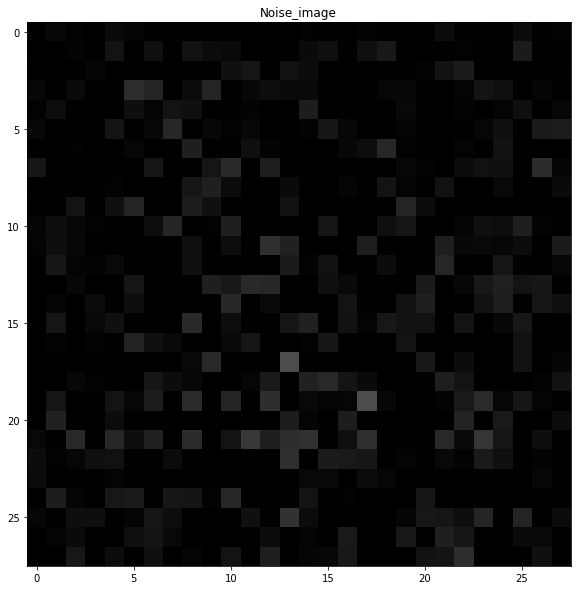

In [ ]:
imshow('Noise_image', g)

## **6. Build the Discriminator Network for DCGAN**

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5,5), (1,1), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.4989554]], shape=(1, 1), dtype=float32)


## **7. Compile the Deep Convolutional Generative Adversarial Network (DCGAN)**

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## **8. Define Training Procedure**

In [ ]:
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## **9. Train DCGAN**

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

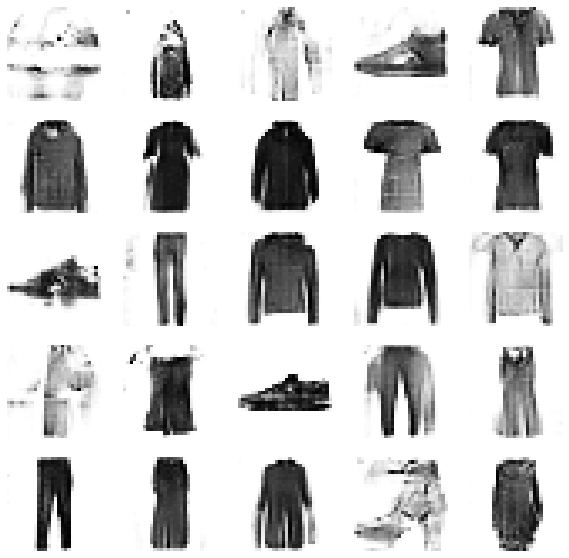

CPU times: user 9min 15s, sys: 20.4 s, total: 9min 35s
Wall time: 9min 45s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## **10. Generate Synthetic Images with DCGAN**

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
#plot_utils.show(generated_images, 8)


In [ ]:
generated_images.shape

TensorShape([32, 28, 28, 1])

In [ ]:
g = np.array(generated_images)
g = g.reshape(g.shape[:3])
g.shape

(32, 28, 28)

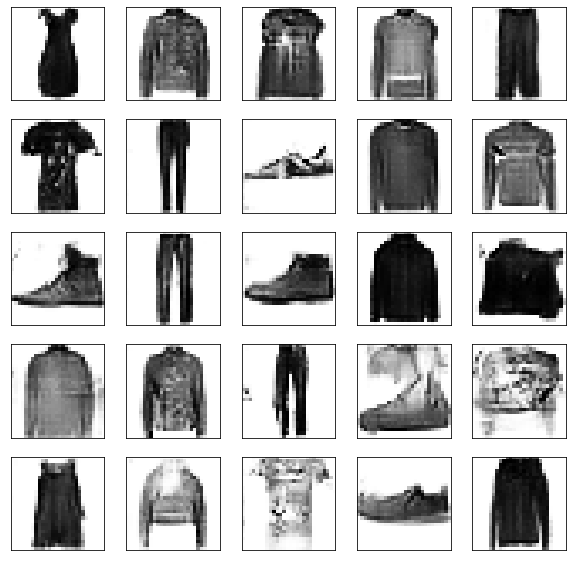

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(g[i], cmap=plt.cm.binary)
plt.show()

## End of Code